<a href="https://colab.research.google.com/github/po04227/Deep-Learning/blob/master/Image_Classification_Using_Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Copyright 2018 Google LLC.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
# Feature Extraction Using a Pretrained Model
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

In [3]:
# Download the weights:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-07-27 07:28:06--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 66.102.1.128, 64.233.167.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|66.102.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   163MB/s    in 0.5s    

2020-07-27 07:28:06 (163 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

In [6]:
# Make the model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False

In [7]:
# Get the output from mixed7
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


In [9]:
# Stick a fully connected classifier on top of last_output:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

In [10]:
# Use the same files and train_generator
!wget --no-check-certificate \
   https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
   /tmp/cats_and_dogs_filtered.zip

--2020-07-27 07:42:28--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 66.102.1.128, 64.233.167.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  36.8MB/s    in 1.8s    

2020-07-27 07:42:30 (36.8 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [11]:
import os
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
# Train the model using the features we extracted
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/10
100/100 - 23s - loss: 0.2102 - acc: 0.9195 - val_loss: 0.0965 - val_acc: 0.9640
Epoch 2/10
100/100 - 23s - loss: 0.1946 - acc: 0.9305 - val_loss: 0.1070 - val_acc: 0.9610
Epoch 3/10
100/100 - 22s - loss: 0.1880 - acc: 0.9285 - val_loss: 0.1011 - val_acc: 0.9660
Epoch 4/10
100/100 - 23s - loss: 0.1722 - acc: 0.9375 - val_loss: 0.1131 - val_acc: 0.9590
Epoch 5/10
100/100 - 22s - loss: 0.1643 - acc: 0.9475 - val_loss: 0.1375 - val_acc: 0.9550
Epoch 6/10
100/100 - 23s - loss: 0.1861 - acc: 0.9405 - val_loss: 0.0880 - val_acc: 0.9710
Epoch 7/10
100/100 - 22s - loss: 0.1604 - acc: 0.9495 - val_loss: 0.1037 - val_acc: 0.9660
Epoch 8/10
100/100 - 22s - loss: 0.1445 - acc: 0.9545 - val_loss: 0.1742 - val_acc: 0.9530
Epoch 9/10
100/100 - 22s - loss: 0.1649 - acc: 0.9480 - val_loss: 0.1675 - val_acc: 0.9560
Epoch 10/10
100/100 - 22s - loss: 0.1677 - acc: 0.9415 - val_loss: 0.1384 - val_acc: 0.9660


In [15]:
# Further Improving Accuracy with Fine-Tuning
from tensorflow.keras.optimizers import SGD

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='binary_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

In [16]:
# Retrain the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/50
100/100 - 24s - loss: 0.2130 - acc: 0.9165 - val_loss: 0.1322 - val_acc: 0.9490
Epoch 2/50
100/100 - 23s - loss: 0.1967 - acc: 0.9175 - val_loss: 0.1369 - val_acc: 0.9520
Epoch 3/50
100/100 - 22s - loss: 0.1691 - acc: 0.9315 - val_loss: 0.1389 - val_acc: 0.9500
Epoch 4/50
100/100 - 23s - loss: 0.1690 - acc: 0.9355 - val_loss: 0.1367 - val_acc: 0.9480
Epoch 5/50
100/100 - 22s - loss: 0.1741 - acc: 0.9225 - val_loss: 0.1359 - val_acc: 0.9500
Epoch 6/50
100/100 - 22s - loss: 0.1795 - acc: 0.9280 - val_loss: 0.1357 - val_acc: 0.9500
Epoch 7/50
100/100 - 22s - loss: 0.1878 - acc: 0.9285 - val_loss: 0.1337 - val_acc: 0.9520
Epoch 8/50
100/100 - 22s - loss: 0.1684 - acc: 0.9325 - val_loss: 0.1334 - val_acc: 0.9520
Epoch 9/50
100/100 - 22s - loss: 0.1647 - acc: 0.9315 - val_loss: 0.1328 - val_acc: 0.9530
Epoch 10/50
100/100 - 22s - loss: 0.1630 - acc: 0.9355 - val_loss: 0.1317 - val_acc: 0.9530
Epoch 11/50
100/100 - 22s - loss: 0.1792 - acc: 0.9300 - val_loss: 0.1319 - val_acc: 0.95

Text(0.5, 1.0, 'Training and validation loss')

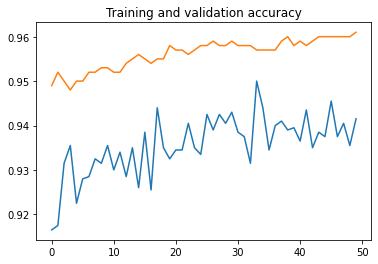

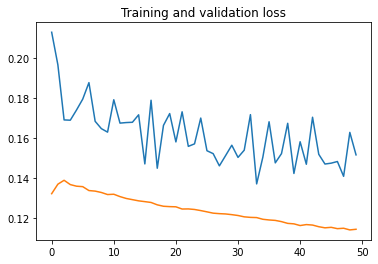

In [17]:
# Plot the training and validation loss and accuracy to show it conclusively:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')